In [27]:
import torch
from matplotlib import pyplot as plt

from lafomo.models import MultiOutputGP
from lafomo.configuration import VariationalConfiguration
from lafomo.utilities.torch import save, load
from lafomo.plot import Plotter

# from model import RNAVelocityLFM
from dataset import SingleCellKidney, Pancreas
from trainer import EMTrainer

import numpy as np

In [2]:
# kidney_path = '/Volumes/ultra/genomics/scRNA-seq/GSE131685_RAW_kidney/velocyto'
# kidney_path = 'F:/genomics/scRNA-seq/GSE131685_RAW_kidney/velocyto'
#
# dataset = SingleCellKidney(calc_moments=True, raw_data_dir=kidney_path)
dataset = Pancreas()
print(dataset.m_observed.shape)
print(dataset.gene_names.shape)
print(dataset[0].shape)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
(3696, 2000) (3696, 2000)
torch.Size([1, 4000, 3696])
(2000,)
torch.Size([1, 3696])


In [31]:
def print_scatter(cells, gene_index, num_connections=10, colors=None):
    traj = trainer.previous_trajectory.mean.transpose(0, 1)
    u = traj[:2000].detach()  # (num_genes, 100, 1)
    s = traj[2000:].detach()  # (num_genes, 100, 1)
    u_y = cells[:2000]  # (num_genes, num_cells)
    s_y = cells[2000:]  # (num_genes, num_cells)

    plt.figure(figsize=(3, 3))
    plt.title(dataset.gene_names[gene_index])

    # Plot trajectory
    plt.plot(s[gene_index], u[gene_index], color='red')

    # Plot cell points
    indices = np.intersect1d(s_y[gene_index, :, 0].nonzero(),
                             u_y[gene_index, :, 0].nonzero())
    plt.scatter(s_y[gene_index, indices, 0], u_y[gene_index, indices, 0], alpha=0.1,s=5, c='black')

    # Plot some connections between cell points and the trajectory line
    for i in range(num_connections):
        plt.scatter(s_y[gene_index, i, 0], u_y[gene_index, i, 0], s=8, c='red')
        line = [
            (s[gene_index, trainer.time_assignments_indices[i]], s_y[gene_index, i, 0]),
            (u[gene_index, trainer.time_assignments_indices[i]], u_y[gene_index, i, 0])
        ]
        plt.plot(line[0], line[1], alpha=0.5, c='purple')
        # trainer.time_assignments_indices[i]
    plt.ylabel('unspliced')
    plt.xlabel('spliced')

In [59]:
import torch
from torch.nn import Parameter

from lafomo.models import OrdinaryLFM
from lafomo.configuration import VariationalConfiguration
from lafomo.utilities.torch import softplus

class RNAVelocityLFM(OrdinaryLFM):
    def __init__(self, num_cells, num_outputs, gp_model, config: VariationalConfiguration, **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        num_genes = num_outputs // 2
        # self.transcription_rate = Parameter(3 * torch.rand(torch.Size([num_genes, 1]), dtype=torch.float64))
        self.splicing_rate = Parameter(2 * torch.rand(torch.Size([num_genes, 1]), dtype=torch.float64))
        self.decay_rate = Parameter(0.1 * torch.rand(torch.Size([num_genes, 1]), dtype=torch.float64))
        self.num_cells = num_cells
        ### Initialise random time assignments
        self.time_assignments = torch.rand(self.num_cells, requires_grad=False)

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        # if (self.nfe % 10) == 0:
        #     print(t)
        self.nfe += 1
        num_samples = h.shape[0]
        num_outputs = h.shape[1]
        h = h.view(num_samples, num_outputs//2, 2)
        u = h[:, :, 0].unsqueeze(-1)
        s = h[:, :, 1].unsqueeze(-1)

        f = self.f[:, :, self.t_index].unsqueeze(2)
        f = softplus(f)
        print(torch.sum(s < 0), torch.sum(u < 0))
        du = f - self.splicing_rate * u
        ds = self.splicing_rate * u - self.decay_rate * s

        h_t = torch.cat([du, ds], dim=1)

        if t > self.last_t:
            self.t_index += 1
        self.last_t = t

        return h_t

    def G(self, f):
        """
        Parameters:
            f: (I, T)
        """
        # nn linear
        return f.repeat(1, self.num_outputs//2//10, 1)  # (S, I, t)

    def predict_f(self, t_predict):
        # Sample from the latent distribution
        q_f = self.get_latents(t_predict.reshape(-1))
        f = q_f.sample([500])  # (S, I, t)
        # This is a hack to wrap the latent function with the nonlinearity. Note we use the same variance.
        f = torch.mean(self.G(f), dim=0)[0]
        return torch.distributions.multivariate_normal.MultivariateNormal(f, scale_tril=q_f.scale_tril)

In [73]:
config = VariationalConfiguration(
    num_samples=20,
    kernel_scale=False
)
num_cells = dataset[0].shape[1]
num_latents = 10
num_inducing = 12  # (I x m x 1)

print('Number of cells:', num_cells)
print('Number of latent GPs (# transcription rates):', num_latents)

step_size = 1e-1

end_t = 12
inducing_points = torch.linspace(0, end_t, num_inducing).repeat(num_latents, 1).view(num_latents, num_inducing, 1)
t_predict = torch.linspace(0, end_t, 80, dtype=torch.float64)

gp_model = MultiOutputGP(inducing_points, num_latents, initial_lengthscale=2)
model = RNAVelocityLFM(num_cells, 4000, gp_model, config)

optimizer = torch.optim.Adam(model.parameters(), lr=0.5)
trainer = EMTrainer(model, optimizer, dataset, batch_size=4000)
plotter = Plotter(model, dataset.gene_names)

Number of cells: 3696
Number of latent GPs (# transcription rates): 10
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(446) tensor(338)
tensor(958) tensor(954)
tensor(1514) tensor(1488)
tensor(1904) tensor(1791)
tensor(2112) tensor(1995)
tensor(2264) tensor(2100)
tensor(2341) tensor(2127)
tensor(2363) tensor(2133)
tensor(2369) tensor(2141)
tensor(2377) tensor(2139)
tensor(2377) tensor(2139)
tensor(2377) tensor(2138)
tensor(2377) tensor(2138)
tensor(2381) tensor(2138)
tensor(2381) tensor(2138)
tensor(2382) tensor(2140)
tensor(2381) tensor(2140)
tensor(2383) tensor(2139)
tensor(2383) tensor(2139)
tensor(2383) tensor(2140)
tensor(2383) tensor(2142)
tensor(2384) tensor(2143)
tensor(2386) tensor(2143)
tensor(2386) tensor(2144)
tensor(2388) tensor(2144)
tensor(2390) tensor(2144)
tensor(2390) tensor(2144)
tensor(2390) tensor(2145)
tensor(2391) tensor(2146)
tensor(2391) tensor(2146)
tensor(2391) tensor(2146)
tensor(2391) tensor(2146)
tensor(2391) tensor(2146)
tensor(2391) tensor(2146)
tensor(23

torch.Size([362, 10])
torch.Size([362, 10])
torch.Size([3, 10, 362])
torch.Size([4000, 3696, 1])


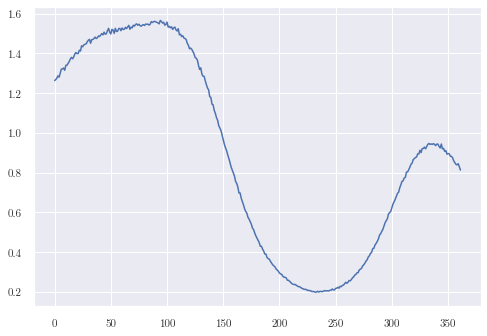

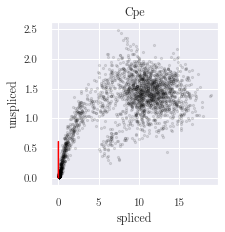

In [81]:
t = inducing_points
t_f = torch.arange(t.min(), t.max()+step_size/3, step_size/3)
# print('feeding gp with ', t_f.shape)
q_f = gp_model(t_f)
print(q_f.mean.shape)
s= softplus(q_f.sample(torch.Size([1]))[0])
print(s.shape)
plt.plot(s[:, 0].detach())

print(q_f.rsample(torch.Size([3])).permute(0, 2, 1).shape)
cpe_index = np.where(dataset.loom.var.index == 'Cpe')[0][0]
data = next(iter(trainer.data_loader))
cells = data.permute(0, 2, 1) # (O, C, 1)
print(cells.shape)
print_scatter(cells, cpe_index, num_connections=0)

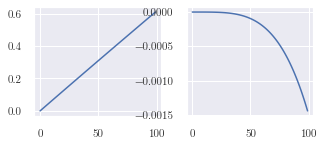

In [82]:
u = trainer.previous_trajectory.mean[:, :2000].detach()
s = trainer.previous_trajectory.mean[:, 2000:].detach()
fig, axes = plt.subplots(ncols=2, figsize=(5, 2))
axes[0].plot(u[:, cpe_index])
axes[1].plot(s[:, cpe_index])


In [6]:
import scvelo as scv
scv.tl.velocity(dataset.loom)

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


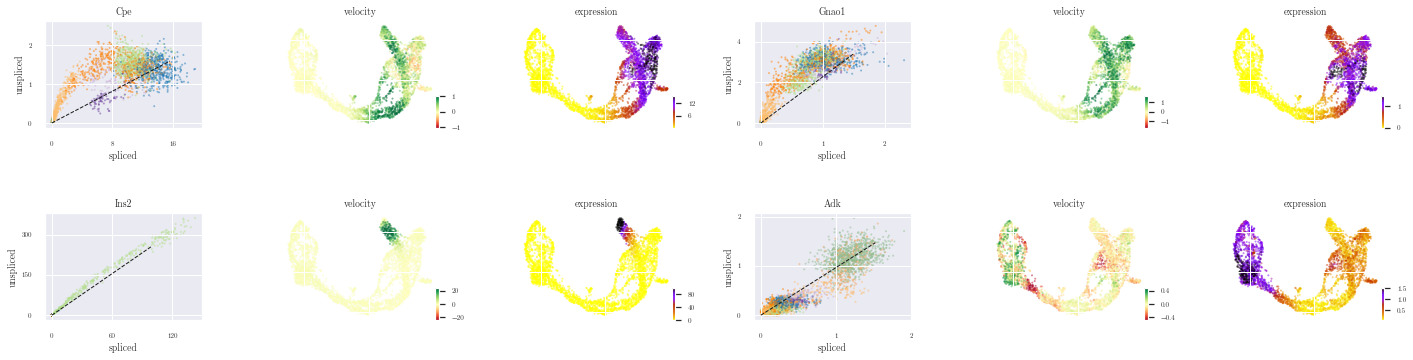

In [7]:
scv.pl.velocity(dataset.loom, ['Cpe',  'Gnao1', 'Ins2', 'Adk'], ncols=2)

(100,)
torch.Size([4000, 3696, 1])


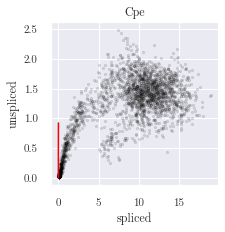

In [57]:
velocity = dataset.loom.layers['velocity']
print(velocity[:100, cpe_index].shape)

data = next(iter(trainer.data_loader))
cells = data.permute(0, 2, 1) # (O, C, 1)
print(cells.shape)
print_scatter(cells, cpe_index, num_connections=0)


### Outputs prior to training:

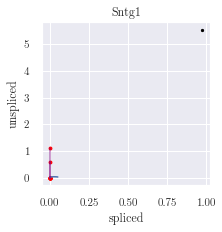

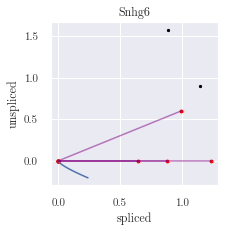

In [6]:
trainer.previous_trajectory = model(trainer.timepoint_choices, step_size=step_size)

# plotter.plot_outputs(t_predict, replicate=0, t_scatter=t_observed,y_scatter=dataset.m_observed, model_kwargs=model_kwargs);
# plotter.plot_latents(t_predict, ylim=(-1, 3), plot_barenco=True, plot_inducing=False)
data = next(iter(trainer.data_loader))
cells = data.permute(0, 2, 1) # (O, C, 1)

for i in range(0, 2):
    print_scatter(cells, i)

In [7]:
import time
start = time.time()

output = trainer.train(20, report_interval=1, step_size=1e-1)
end = time.time()
print(end - start)

estep done
num t: torch.Size([40])
torch.Size([4000, 100]) torch.Size([4000, 100])
Epoch 001/020 - Loss: 41982.07 (41982.07 0.00) λ: [0.3132617  0.3132617  0.3132617  1.3132615  0.3132617  0.3132617
 0.3132623  0.3132617  0.31326172 1.3132616 ]
estep done
num t: torch.Size([6])
torch.Size([4000, 100]) torch.Size([4000, 100])
Epoch 002/020 - Loss: inf (31334.78 inf) λ: [0.53754765 0.15856917 0.1892144  1.9694493  0.13693179 0.13018654
 0.16569789 0.13770726 0.4195531  1.9664522 ]
estep done
num t: torch.Size([31])


RuntimeError: symeig_cpu: For batch 4: the algorithm failed to converge; 30 off-diagonal elements of an intermediate tridiagonal form did not converge to zero.

In [8]:
model.gp_model.covar_module.lengthscale.shape

torch.Size([10, 1, 1])

### Outputs after training

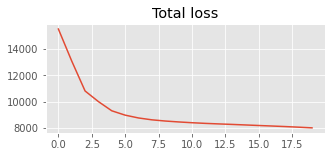

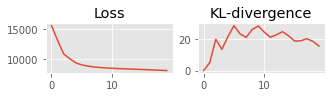

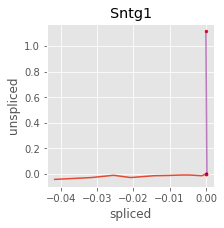

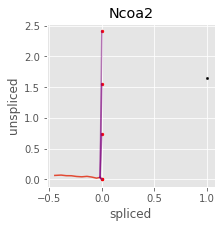

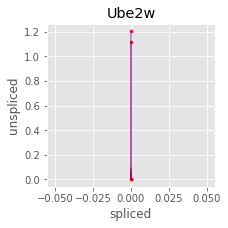

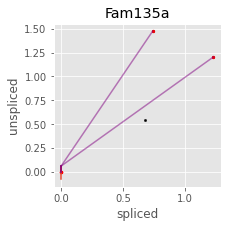

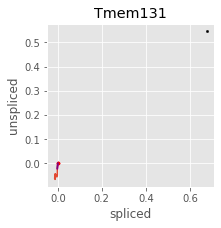

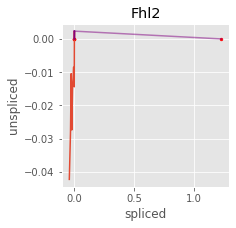

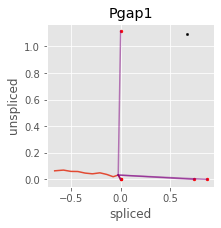

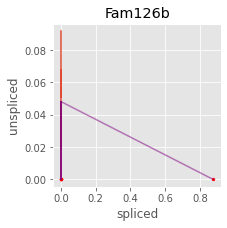

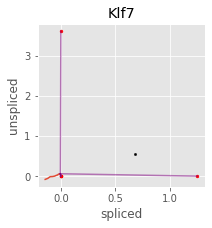

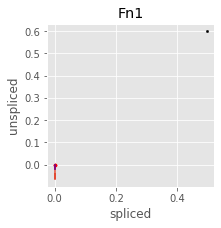

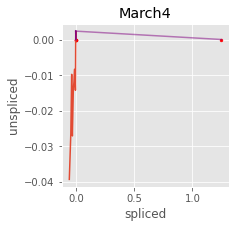

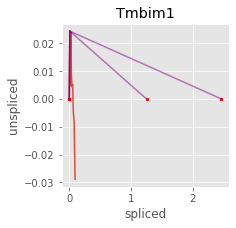

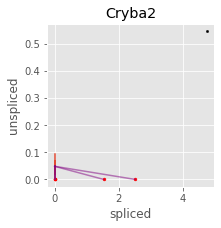

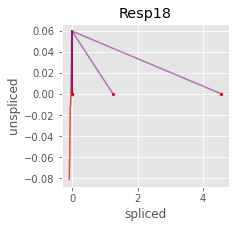

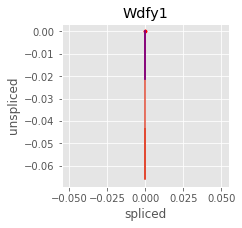

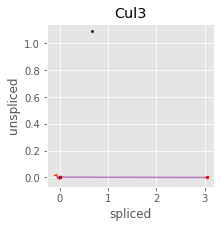

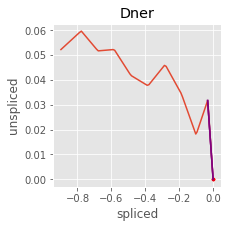

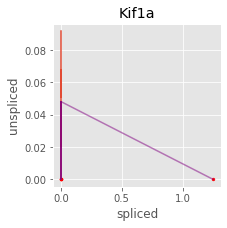

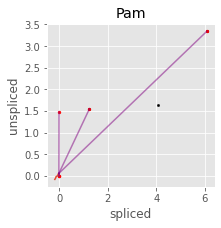

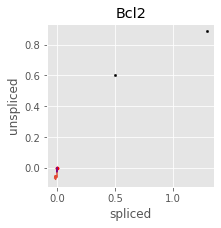

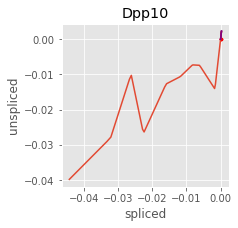

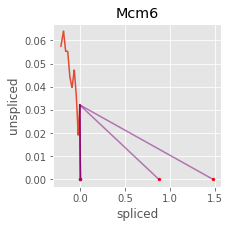

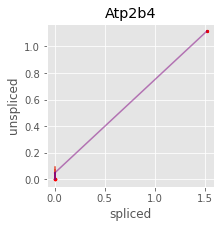

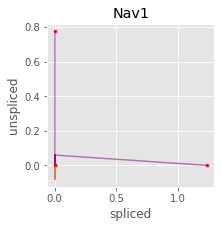

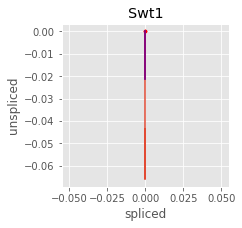

In [9]:
plotter.plot_losses(trainer, last_x=100)
data = next(iter(trainer.data_loader))
cells = data.permute(0, 2, 1) # (O, C, 1)

for i in range(0, 50, 2):
    print_scatter(cells, i, num_connections=0)

In [10]:
traj = trainer.previous_trajectory.mean.transpose(0, 1)
u = traj[:2000].detach()  # (num_genes, 100, 1)
s = traj[2000:].detach()  # (num_genes, 100, 1)
u_y = cells[:2000]  # (num_genes, num_cells)
s_y = cells[2000:]  # (num_genes, num_cells)
print(s_y.shape, s.transpose(1, 2).shape)
u_residual = u_y[:, :1000] - u.transpose(1, 2)
s_residual = s_y[:, :1000] - s.transpose(1, 2)
print(u_residual.shape) # (genes, cells, timepoints)
residual = u_residual.square() + s_residual.square()
# residual = residual.sum(dim=0).argmin(dim=1).type(torch.long)
gene_index = 0
residual = residual[gene_index]
print(residual.shape)
residual_indices = residual.argmin(dim=1)
print(residual_indices.shape)
residual_minimum = residual.min(dim=1).values
print('min', residual_minimum.shape)
residual_sort_indices = residual_minimum.argsort()
# print(residual_sort_indices)
# for this gene, the indices of the closest timepoint for all cells

# Plot trajectory
plt.scatter(s[gene_index], u[gene_index])

# Plot cell points
indices = np.intersect1d(s_y[gene_index, :, 0].nonzero(),
                         u_y[gene_index, :, 0].nonzero())
plt.scatter(s_y[gene_index, indices, 0], u_y[gene_index, indices, 0], s=5, c='black')

for cell_index in residual_sort_indices[:100]:
    plt.scatter(s_y[gene_index, cell_index, 0], u_y[gene_index, cell_index, 0], s=8, c='red')
    line = [
    (s[gene_index, residual_indices[cell_index]], s_y[gene_index, cell_index, 0]),
    (u[gene_index, residual_indices[cell_index]], u_y[gene_index, cell_index, 0])
    ]
    plt.plot(line[0], line[1], alpha=0.8, c='purple')
# plt.xlim(0.015, 0.071)
# plt.ylim(0.22, 0.25)


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [ ]:
print(trainer.timepoint_choices[trainer.time_assignments_indices])
print(trainer.time_assignments_indices.shape)


In [ ]:
# plotter.plot_outputs(t_predict, replicate=0, ylim=(0, 3),
#                      t_scatter=t_observed, y_scatter=dataset.m_observed,
#                      model_kwargs=model_kwargs);
# plotter.plot_latents(t_predict, ylim=(-2, 4), plot_barenco=True, plot_inducing=False)
# plotter.plot_kinetics()
# plotter.plot_convergence(trainer)

In [ ]:
print(model.decay_rate)
print(model.transcription_rate)

In [ ]:
save(model, 'rnavelocity')

In [ ]:
do_load = False
if do_load:
    model = load('rnavelocity', RNAVelocityLFM, 2000, 1,
                 t_inducing, dataset, extra_points=2, fixed_variance=dataset.variance)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    trainer = EMTrainer(model, optimizer, dataset)
print(do_load)